In [26]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
from typing import List, Dict, Optional
from datetime import timedelta
from collections.abc import Mapping

def fmt_seconds(seconds: float) -> str:
    if seconds is None or np.isnan(seconds):
        return "–"
    td = timedelta(seconds=int(seconds))
    h, remainder = divmod(td.seconds, 3600)
    m, s = divmod(remainder, 60)
    h += td.days * 24
    return f"{h}h {m}m {s}s"

class PerformanceDashboard:
    """
    Visualize inference performance metrics grouped by supervoxel_type.
    - Line plots: inference_time_sec, cache_hit_ratio_percent (mean ± std).
    - Table: runtime duration and number of samples (mean ± std).
    Filters out runs with group == "ABPC".
    """

    def __init__(
        self,
        entity: str = "giuliosichili",
        project: str = "automi",
        group_key: str = "group",
        supervoxel_key: str = "supervoxel_type",
        excluded_groups: List[str] = ["ABPC"],
        page_size: int = 256,
    ):
        self.entity = entity
        self.project = project
        self.page_size = page_size
        self.group_key = group_key
        self.supervoxel_key = supervoxel_key
        self.excluded_groups = excluded_groups
        self._api = wandb.Api()

    def run(self, supervoxel_type: str, save: bool = False, dpi: int = 300):
        runs = self._fetch_runs(supervoxel_type)
        if not runs:
            print(f"[warning] No runs found for supervoxel_type='{supervoxel_type}'")
            return
        print(f"[info] Found {len(runs)} runs for supervoxel_type='{supervoxel_type}'")

        metrics = self._collect_metrics(runs)
        fig = self._plot(metrics, supervoxel_type)

        if save:
            fname = f"performance_dashboard_{supervoxel_type.replace(' ', '_')}.png"
            fig.savefig(fname, dpi=dpi, bbox_inches="tight")
            print(f"[saved] {fname}")

        plt.show()

    def _fetch_runs(self, supervoxel_type: str) -> List[wandb.apis.public.Run]:
        # after repeating experiments with aggregation_function != true_positive_aggregation, we must select two different groups:
        path = f"{self.entity}/{self.project}"
        filters = {
            f"config.{self.supervoxel_key}": {"$eq": supervoxel_type},
            "$or": [
                {
                    f"config.{self.group_key}": {"$eq": "fixed-aggregation"}
                },
                {
                    f"config.{self.group_key}": {"$exists": False},
                    "config.aggregation_function": {"$eq": "true_positive_aggregation"}
                },
            ]
        }
        return list(self._api.runs(path, filters=filters))

    def _collect_metrics(self, runs: List[wandb.apis.public.Run]) -> Dict:
        # Ora salviamo (steps, values) per ogni run, non solo i valori senza indice.
        curves = {"inference_time_sec": [], "cache_hit_ratio_percent": []}
        scalars = {"runtime_sec": [], "n_samples": []}

        for r in runs:
            per_run_series = {k: {} for k in curves}

            try:
                history = r.history(keys=list(curves), pandas=False)
                for row in history:
                    step = row.get("_step", row.get("step"))
                    if step is None:
                        continue
                    for key in curves:
                        val = row.get(key, None)
                        if val is not None:
                            per_run_series[key][int(step)] = float(val)
            except Exception as e:
                print(f"[warning] Failed to read history from run {r.id}: {e}")

            for key in curves:
                if len(per_run_series[key]) == 0:
                    print(f"[warning] No usable history for {key} in run {r.id}")
                    continue
                steps_sorted = np.array(sorted(per_run_series[key].keys()), dtype=int)
                values_sorted = np.array([per_run_series[key][s] for s in steps_sorted], dtype=float)
                curves[key].append({"steps": steps_sorted, "values": values_sorted})

            # scalari dal summary
            try:
                total_sec = float(r.summary.get("_runtime", np.nan))
                print(f"Run {r.id} runtime: {fmt_seconds(total_sec)}")
                if not np.isnan(total_sec):
                    scalars["runtime_sec"].append(total_sec)
            except Exception:
                pass

            # n_samples: ora dalla config (con fallback)
            n_samples = self._get_n_samples(r)
            if not np.isnan(n_samples):
                scalars["n_samples"].append(n_samples)
            else:
                print(f"[info] n_samples non trovato in config/summary/history per run {r.id}")

        return {"curves": curves, "scalars": scalars}
    


    def _plot(self, data: Dict, supervoxel_type: str):
        curves = data["curves"]
        scalars = data["scalars"]
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Helper: aggrega su un asse dei passi condiviso (unione dei passi di tutti i run)
        def aggregate_over_steps(series_list):
            # series_list: List[{"steps": np.array, "values": np.array}]
            # Unione dei passi
            all_steps = sorted(set(int(s) for d in series_list for s in d["steps"]))
            if len(all_steps) == 0:
                return np.array([]), np.array([]), np.array([])
            step_to_idx = {s: i for i, s in enumerate(all_steps)}

            M = np.full((len(series_list), len(all_steps)), np.nan, dtype=float)
            for i, d in enumerate(series_list):
                for s, v in zip(d["steps"], d["values"]):
                    j = step_to_idx[int(s)]
                    M[i, j] = v

            mu = np.nanmean(M, axis=0)
            # nanstd con ddof=1 -> NaN se count<2; sostituiamo con 0
            with np.errstate(invalid="ignore"):
                sd = np.nanstd(M, axis=0, ddof=1)
            sd = np.where(np.isnan(sd), 0.0, sd)
            return np.array(all_steps, dtype=int), mu, sd

        for ax, key, label in zip(
            axes,
            ["inference_time_sec", "cache_hit_ratio_percent"],
            ["Inference Time (s)", "Cache Hit Ratio (%)"],
        ):
            series_list = curves[key]
            if len(series_list) == 0:
                ax.set_visible(False)
                continue

            x, mu, sd = aggregate_over_steps(series_list)
            ax.plot(x, mu, lw=2.0, label=label)
            ax.fill_between(x, mu - sd, mu + sd, alpha=0.2)
            ax.set_title(key)
            ax.set_xlabel("Step")
            ax.set_ylabel(label)
            ax.grid(True)

        # Tabella con runtime e n_samples + global avg of time/hits
        rt = np.array(scalars["runtime_sec"])
        ns = np.array(scalars["n_samples"])
        rt_mu = np.nanmean(rt) if rt.size else np.nan
        rt_sd = np.nanstd(rt, ddof=1) if rt.size > 1 else (0.0 if rt.size == 1 else np.nan)
        ns_mu = np.nanmean(ns) if ns.size else np.nan
        ns_sd = np.nanstd(ns, ddof=1) if ns.size > 1 else (0.0 if ns.size == 1 else np.nan)

        # Compute scalar global averages across runs for time and hits
        def _aggregate_scalar(series_list):
            vals = []
            for d in series_list:
                v = np.nanmean(np.array(d.get("values", []), dtype=float)) if len(d.get("values", [])) > 0 else np.nan
                vals.append(v)
            arr = np.array(vals, dtype=float)
            mu = np.nanmean(arr) if arr.size else np.nan
            sd = np.nanstd(arr, ddof=1) if arr.size > 1 else (0.0 if arr.size == 1 else np.nan)
            return mu, sd

        it_mu, it_sd = _aggregate_scalar(curves["inference_time_sec"])
        ch_mu, ch_sd = _aggregate_scalar(curves["cache_hit_ratio_percent"])

        

        table_ax = fig.add_axes([0.25, -0.35, 0.5, 0.3])
        table_ax.axis("off")
        table_ax.table(
            cellText=[
                [fmt_seconds(rt_mu), f"± {fmt_seconds(rt_sd)}"],
                [f"{ns_mu:.1f}" if not np.isnan(ns_mu) else "–", f"± {ns_sd:.1f}" if not np.isnan(ns_sd) else "–"],
                [f"{it_mu:.2f} s" if not np.isnan(it_mu) else "–", f"± {it_sd:.2f} s" if not np.isnan(it_sd) else "–"],
                [f"{ch_mu:.1f} %" if not np.isnan(ch_mu) else "–", f"± {ch_sd:.1f} %" if not np.isnan(ch_sd) else "–"],
            ],
            rowLabels=["Runtime", "#Samples", "Avg Inference Time (s)", "Avg Cache Hit (%)"],
            colLabels=["Mean", "Std Dev"],
            cellLoc="center",
            loc="center",
        ).scale(1.2, 1.2)

        fig.suptitle(f"Inference Performance — SV: {supervoxel_type}", fontsize=14)
        fig.tight_layout(rect=[0, 0.08, 1, 1])
        return fig
    
    def _get_n_samples(self, r: wandb.apis.public.Run) -> float:
        """
        Cerca n_samples in ordine: config (anche annidata) -> summary -> history.
        Ritorna np.nan se non trovato.
        """
        candidate_keys = ["n_samples", "num_samples", "n_total", "dataset_size"]

        def deep_find(d: Mapping) -> Optional[float]:
            for k, v in d.items():
                if k in candidate_keys and isinstance(v, (int, float)):
                    return float(v)
                if isinstance(v, Mapping):
                    found = deep_find(v)
                    if found is not None:
                        return found
                elif isinstance(v, list):
                    for it in v:
                        if isinstance(it, Mapping):
                            found = deep_find(it)
                            if found is not None:
                                return found
            return None

        # 1) CONFIG
        try:
            conf = dict(r.config)  # DotDict -> dict
            val = deep_find(conf)
            if val is not None:
                return val
        except Exception:
            pass

        # 2) SUMMARY (fallback)
        for k in candidate_keys:
            try:
                v = r.summary.get(k, None)
                if v is not None:
                    return float(v)
            except Exception:
                continue

        # 3) HISTORY (fallback: prima occorrenza)
        try:
            for row in r.history(keys=candidate_keys, pandas=False):
                for k in candidate_keys:
                    v = row.get(k, None)
                    if v is not None:
                        return float(v)
        except Exception:
            pass

        return np.nan

In [27]:
dash = PerformanceDashboard(excluded_groups=["ABPC", "ABPC-volumes"])

[info] Found 32 runs for supervoxel_type='full-organs'
Run jzli62c8 runtime: 0h 51m 10s
Run 15jq6cg1 runtime: 1h 3m 22s
Run 1j35jqwu runtime: 1h 12m 30s
Run fv6ygmij runtime: 0h 54m 1s
Run 6pt1aje3 runtime: 1h 1m 12s
Run c2c7dat1 runtime: 1h 4m 18s
Run a0vv3k0k runtime: 0h 51m 30s
Run zrr96tjr runtime: 0h 55m 59s
Run lqohurz4 runtime: 0h 51m 48s
Run t6i047ls runtime: 1h 7m 48s
Run tfzi4o8j runtime: 0h 50m 57s
Run eukt19xk runtime: 1h 9m 4s
Run of5quxf1 runtime: 0h 51m 26s
Run 6j08ggxh runtime: 1h 8m 39s
Run euo02tru runtime: 1h 4m 20s
Run hik7tbvj runtime: 1h 11m 35s
Run 7cfgyf7g runtime: 1h 3m 52s
Run cwfjwtva runtime: 1h 10m 51s
Run r5bwzdxo runtime: 1h 3m 31s
Run 8y0pesiu runtime: 1h 14m 14s
Run otm3bw4d runtime: 1h 10m 28s
Run fb8inyln runtime: 1h 13m 15s
Run kx7e2cw0 runtime: 0h 56m 14s
Run kwbywi1w runtime: 0h 55m 58s
Run u6pkic1t runtime: 1h 14m 8s
Run vpfjtk9x runtime: 0h 56m 11s
Run 34fquy7e runtime: 0h 53m 24s
Run yfma4zx4 runtime: 1h 1m 48s
Run 10ctc40c runtime: 0h 53m 13s
R

/var/folders/7p/yjn93vy92vs94f3hdj934z3w0000gn/T/ipykernel_91241/287633479.py:210: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.08, 1, 1])


[saved] performance_dashboard_full-organs.png


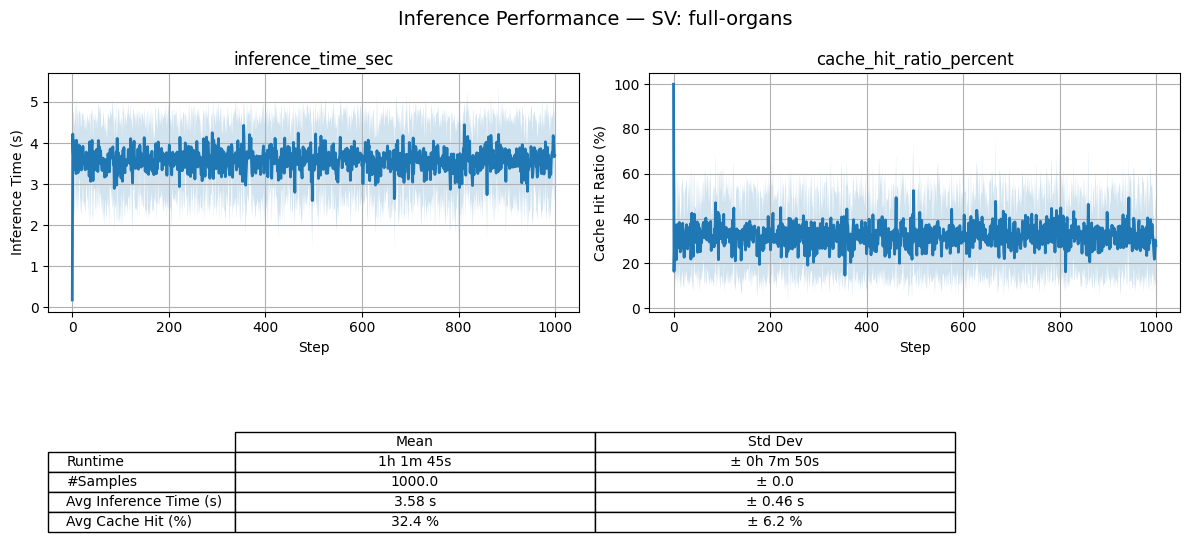

In [28]:
dash.run(supervoxel_type="full-organs", save=True)

[info] Found 32 runs for supervoxel_type='FCC-organs'
Run skuawcpx runtime: 2h 46m 47s
Run 1ks9e69w runtime: 3h 15m 23s
Run awvg6u4p runtime: 3h 38m 57s
Run ovudon23 runtime: 2h 58m 18s
Run 83t1wvyw runtime: 3h 37m 53s
Run mfmlkuyp runtime: 3h 28m 56s
Run 21bpzpe1 runtime: 3h 4m 30s
Run 8y8v8f1o runtime: 3h 16m 3s
Run d9ayexak runtime: 2h 40m 15s
Run d4fu3y41 runtime: 2h 45m 27s
Run o0rk73zz runtime: 2h 46m 10s
Run tx24msmq runtime: 3h 13m 46s
Run ihsylr85 runtime: 3h 12m 1s
Run zxn7eggz runtime: 3h 8m 19s
Run otavocx3 runtime: 3h 36m 24s
Run 8pdz473b runtime: 3h 36m 22s
Run z99jogvq runtime: 3h 34m 31s
Run 6mdyo869 runtime: 2h 54m 5s
Run 3xguntuf runtime: 2h 52m 25s
Run lkiod7ec runtime: 2h 53m 7s
Run 5jp0edyy runtime: 3h 34m 12s
Run xi8s4o2q runtime: 3h 37m 10s
Run tiwn5ctn runtime: 3h 36m 9s
Run gu0z8129 runtime: 3h 32m 34s
Run 1yfflupz runtime: 3h 37m 10s
Run dk7h68ml runtime: 3h 32m 3s
Run zzkd6lfp runtime: 3h 5m 55s
Run ryukr0na runtime: 3h 3m 6s
Run zxle55ls runtime: 3h 3m 33s
R

/opt/anaconda3/envs/torch/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/7p/yjn93vy92vs94f3hdj934z3w0000gn/T/ipykernel_91241/287633479.py:210: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.08, 1, 1])


[saved] performance_dashboard_FCC-organs.png


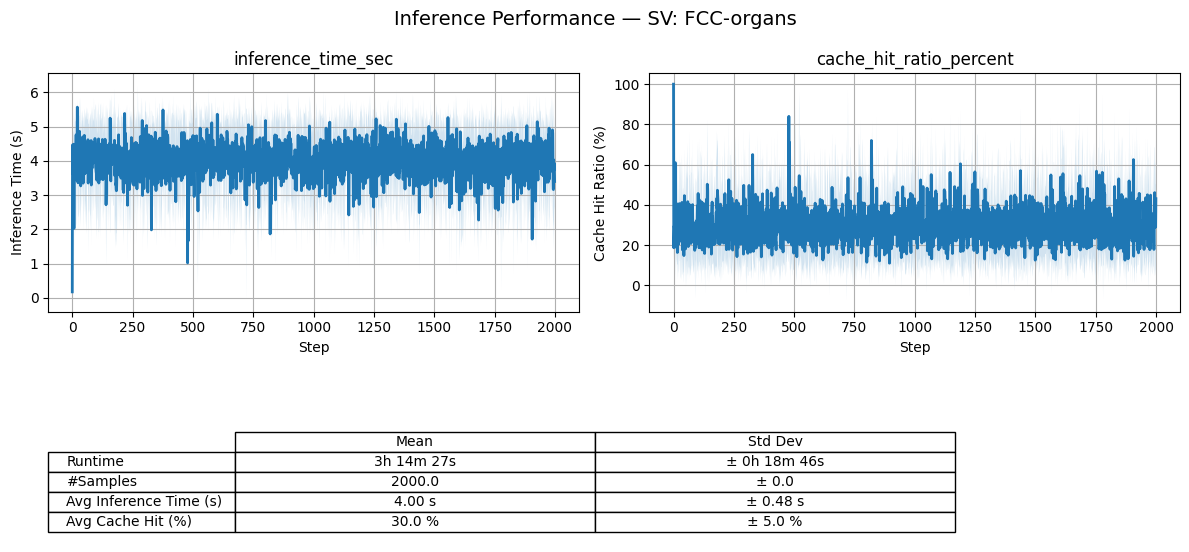

In [29]:
dash.run(supervoxel_type="FCC-organs", save=True)

[info] Found 32 runs for supervoxel_type='FCC'
Run atahxrw3 runtime: 2h 6m 27s
Run qlj25wck runtime: 2h 40m 0s
Run r63tskfy runtime: 3h 13m 45s
Run ryfsedw0 runtime: 2h 42m 43s
Run 1wfxozbx runtime: 2h 38m 55s
Run pw2xjz48 runtime: 3h 7m 23s
Run rr8hv1ck runtime: 2h 37m 10s
Run ks9g2zm9 runtime: 2h 37m 58s
Run 2x4om9kf runtime: 1h 56m 36s
Run 49uayd0s runtime: 1h 55m 30s
Run ktmk926a runtime: 1h 56m 23s
Run 1ogadnxt runtime: 2h 21m 18s
Run 1s987v2g runtime: 2h 24m 57s
Run 1uhbq9g3 runtime: 2h 24m 15s
Run f3gw77lh runtime: 2h 57m 42s
Run m84neu1x runtime: 2h 58m 0s
Run zef637ue runtime: 2h 57m 57s
Run gnc3urm9 runtime: 2h 24m 14s
Run 5eb9wq4a runtime: 2h 22m 36s
Run 5jtpq3ie runtime: 2h 24m 24s
Run pgs6r8ij runtime: 2h 25m 41s
Run 7luum4p0 runtime: 2h 24m 20s
Run krh8u5lm runtime: 2h 26m 38s
Run ggqvsons runtime: 2h 48m 0s
Run 2awvol15 runtime: 2h 51m 12s
Run yx2qo16b runtime: 2h 51m 46s
Run z20chu4z runtime: 2h 24m 18s
Run pnitxupn runtime: 2h 23m 28s
Run iw7lnz5z runtime: 2h 22m 13s
R

/var/folders/7p/yjn93vy92vs94f3hdj934z3w0000gn/T/ipykernel_91241/287633479.py:210: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.08, 1, 1])


[saved] performance_dashboard_FCC.png


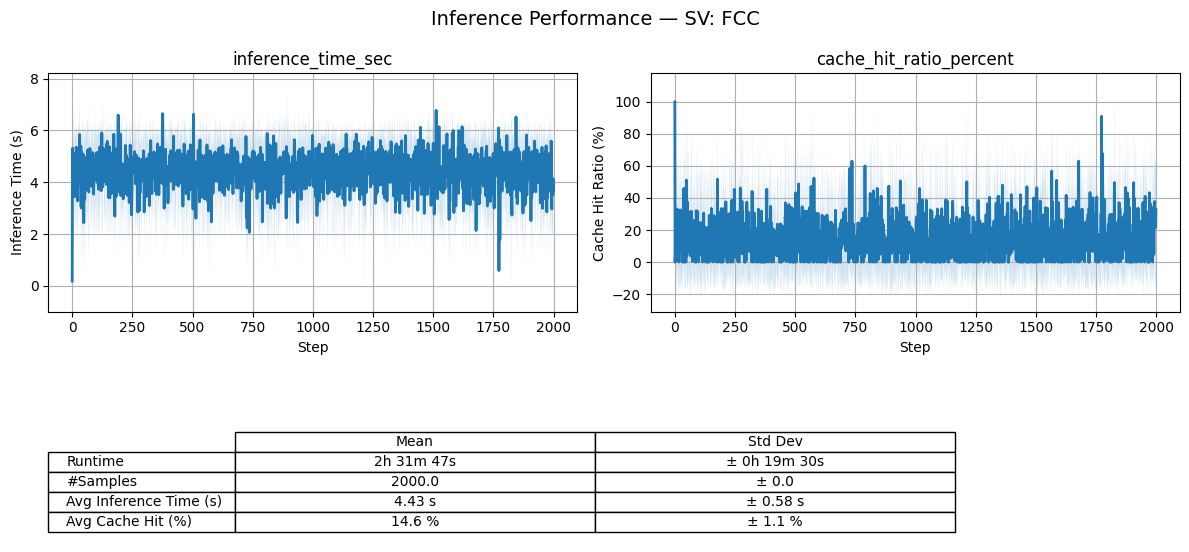

In [30]:
dash.run(supervoxel_type="FCC", save=True)

In [31]:
"""api = wandb.Api()
run = api.run("giuliosichili/automi/jzli62c8")
print(run.summary.keys())
print(run.history(keys=["inference_time_sec", "cache_hit_ratio_percent"]))"""

'api = wandb.Api()\nrun = api.run("giuliosichili/automi/jzli62c8")\nprint(run.summary.keys())\nprint(run.history(keys=["inference_time_sec", "cache_hit_ratio_percent"]))'